In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import LogNorm
from joblib import Parallel,delayed
from multiprocessing import cpu_count
import pandas as pd
from tqdm.notebook import tqdm
import os
import cmath
import time
import math
import bilby
import tempfile
import h5py
from tkinter import Tcl

from scipy.interpolate import interp1d,RectBivariateSpline
from scipy.integrate import solve_ivp
from scipy.special import factorial2,beta
from scipy.integrate import quad,nquad
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,toms748,minimize
import scipy.stats as st
import seaborn as sns

# Statistical Functions

In [4]:
class gaussian:
    def __init__(self,mean,cov):
        self.mean=mean
        self.cov=cov
        
    def UV(self,x):
        sig= (self.cov)**(1/2)
        mu= self.mean
        p= 1./(sig*np.sqrt(2.*np.pi))*np.exp(-np.power((x - mu)/sig, 2.)/2)
        return p
    
    def MV(self,x):
        x=np.array(x)
        mu=np.array(self.mean)
        cov=np.array(self.cov)
        part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
        part2 = (-1/2) * ((x-mu).dot(np.linalg.inv(cov))).dot((x-mu).T)
        return part1 * np.exp(part2)
    
    def __call__(self,x):
        if type(self.mean)==list:
            return self.MV(x)
        else:
            return self.UV(x)
    
def CI2sig(dx,CI):
    alpha= 1-CI
    z_score= st.norm.ppf(1-alpha/2)
    sig= dx/z_score
    return sig

def uniform(x,a,b):
    if min([a,b])<=x<=max([a,b]):
        return 1/abs(b-a)
    else:
        return 0

def CI_calc(x,px,f,typ="mean"):
    if typ=="mean":
        mean= quad(interp1d(x,x*px),x[0],x[-1])[0]
    elif typ=="median":
        mean= x[np.argmax(px)]
    minus= toms748(lambda X: quad(interp1d(x,px),x[0],X)[0]-(1-f)/2,x[0],mean)
    plus= toms748(lambda X: quad(interp1d(x,px),x[0],X)[0]-(1+f)/2,mean,x[-1])
    return [mean,plus,minus]
  

def array_from_samp(x,N,perc=10):
    xmin= min(x)
    xmax= max(x)
    mean= (xmax+xmin)/2
    f= perc/100
    xmin= xmin - mean*f
    xmax= xmax + mean*f
    return np.linspace(xmin,xmax,N)

class integrator:
    def __init__(self,func,limits,N):
        n= len(limits)
        vals_range= []
        for i in range(n):
            lim= limits[i]
            vals_range.append(np.linspace(lim[0],lim[1],N))
            
        vals_grid= np.meshgrid(*vals_range)
        vals=[]
        for val in vals_grid:
            vals.append(val.flatten())
            
        vals= np.transpose(vals)
        P= []
        for val in vals:
            P.append(func(*val))
            
        self.P_grid= np.reshape(P,[N]*n)
        self.vals_range= vals_range
        
    def __call__(self):
        return sum(self.P_grid.flatten())
    
def normalize(x,px):
    x2p= interp1d(x,px)
    norm= quad(x2p,x[0],x[-1])[0]
    return np.array(px)/norm

def metropolis_hastings(target_density,x0,burnin_size=1000,size=50000,pbar=True):
    size += burnin_size
    xt = x0
    n= len(x0)
    samples = []
    for i in tqdm(range(size),disable=not(pbar)):
        xt_candidate = np.random.multivariate_normal(xt, np.eye(n))
        accept_prob = (target_density(xt_candidate))/(target_density(xt))
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
    samples = np.array(samples[burnin_size:])
    return samples

class sampling_2d:
    def __init__(self,pdf,x_lim,y_lim,n_grid=100,n_samp=2000):
        x_range= np.linspace(*x_lim,n_grid)
        y_range= np.linspace(*y_lim,n_grid)
        
        P_xy= np.transpose(Parallel(n_jobs=-1,mmap_mode="r+")(delayed(lambda y: [pdf(x,y) for x in x_range])(y) for y in tqdm(y_range))) 
        self.xy2P= RectBivariateSpline(x_range,y_range,P_xy)
        self.x_range=x_range
        self.y_range=y_range
        
        Px= np.sum(P_xy,axis=1)
        c2x= self.cdf2x(x_range,Px)
        c= np.linspace(0,1,n_samp)
        self.x_samples= c2x(c)
        
    def cdf2x(self,x,px):
        px= normalize(x,px)
        cdf= np.cumsum(px)
        c2x= interp1d(cdf/cdf[-1],x,bounds_error=False,fill_value=(x[0],x[-1]))
        return c2x
    
    def generate(self):
        x_samples= self.x_samples
        y_range= self.y_range
        
        def sub_func(x):
            py= [self.xy2P(x,y)[0][0] for y in y_range]
            c2y= self.cdf2x(y_range,py)
            c= np.random.uniform(0,1,1)
            y_samp= c2y(c)[0]
            return y_samp
        
        y_samples= Parallel(n_jobs=-1,mmap_mode="r+")(delayed(sub_func)(xi) for xi in tqdm(x_samples))
        
        return x_samples, np.array(y_samples)

In [25]:
def error_str(data_conf):
    
    if type(data_conf[0])==list or type(data_conf[0])==tuple or type(data_conf[0])==np.ndarray:
        str_store= []
        for data in data_conf:
            x,x_plus,x_minus= data
            if x_plus>x_minus:
                delx_plus= x_plus- x
                delx_minus= x - x_minus
            else:
                delx_plus= x_minus- x
                delx_minus= x - x_plus
            str_store.append("$%0.2f^{+%0.2f}_{-%0.2f}$" %(x,delx_plus,delx_minus))
    else:
        x,x_plus,x_minus= data_conf
        if x_plus>x_minus:
            delx_plus= x_plus- x
            delx_minus= x - x_minus
        else:
            delx_plus= x_minus- x
            delx_minus= x - x_plus
        str_store= "$%0.2f^{+%0.2f}_{-%0.2f}$" %(x,delx_plus,delx_minus)

    return str_store

# Data Extraction

In [5]:
class Ensemble_Extraction:
    def __init__(self,path):
        self.Ensemble_Data= self.Extraction(path)
        
        Data= dict()
        Data["M"]= []
        Data["R"]= []
        Data["C"]= []
        Data["L"]= []
        Data["f_CA"]= []
        Data["f_GR"]= []
        Data["tau_GR"]= []
        
        self.Data= Data

    def M_extract(self,Mass,M,Ec,*params):
        Mmax= max(M)
        if Mass>Mmax:
            return None
        
        M2Ec= interp1d(M,Ec)
        Ec_at_M= M2Ec(Mass)
        P_at_M= []
        for P in params:
            P_at_M.append(interp1d(Ec,P)(Ec_at_M))
            
        return P_at_M
    
    def Extraction(self,path):

        Data= dict()
        for file in tqdm(Tcl().call('lsort', '-dict', os.listdir(path))):
            if file.endswith(".json"): dat= readDict(path+file)
            else: continue

            Ec_array= dat["Ec"]
            M_array= dat["M"]
            R_array= dat["R"]
            C_array= dat["C"]
            Lamda_array= dat["Lambda"]
            f_array= dat["NRO_GR"]["f"]
            tao_array= dat["NRO_GR"]["DT"]

            if min(tao_array)<0.1 or min(M_array)<0.7:
                continue

            eos= file[:-5]
            Data[eos]= dict()
            Data[eos]["Ec"]= Ec_array
            Data[eos]["M"]= M_array
            Data[eos]["R"]= R_array
            Data[eos]["C"]= C_array
            Data[eos]["L"]= Lamda_array
            Data[eos]["f_CA"]= dat["NRO_CA"]["f"]
            Data[eos]["f_GR"]= f_array
            Data[eos]["tau_GR"]= tao_array

        return Data
    
    def __call__(self,*Mass):
        Data= self.Data
        
        if len(Mass)>=1:
            for m in Mass:
                if m==max:
                    Data["M_max"]= []
                    Data["R_max"]= []
                    Data["L_max"]= []
                    Data["f_CA_max"]= []
                    Data["f_GR_max"]= []
                    Data["tau_GR_max"]= []
                    continue
                Data["R_%s" %m]= []
                Data["L_%s" %m]= []
                Data["f_CA_%s" %m]= []
                Data["f_GR_%s" %m]= []
                Data["tau_GR_%s" %m]= []
        
        for dat in tqdm(self.Ensemble_Data.values()):
            Ec= dat["Ec"]
            M= dat["M"]
            R= dat["R"]
            C= dat["C"]
            L= dat["L"]     
            f= dat["f_GR"] 
            t= dat["tau_GR"]
            f_ca= dat["f_CA"]
                        
            Data["M"].append(M)
            Data["R"].append(R)
            Data["C"].append(C)
            Data["L"].append(L)
            Data["f_GR"].append(f)
            Data["f_CA"].append(f_ca)
            Data["tau_GR"].append(t)
            
            if len(Mass)>=1:
                for m in Mass:
                    if m==max:
                        Data["M_max"].append(M[-1])
                        Data["R_max"].append(R[-1])
                        Data["L_max"].append(L[-1])
                        Data["f_GR_max"].append(f[-1])
                        Data["f_CA_max"].append(f_ca[-1])
                        Data["tau_GR_max"].append(t[-1])
                        continue
                    p_at_m= self.M_extract(m,M,Ec,R,L,f,f_ca,t)
                    if p_at_m==None:
                        continue
                    R_m,L_m,f_m,f_ca_m,t_m= p_at_m
                    Data["R_%s" %m].append(R_m)
                    Data["L_%s" %m].append(L_m)
                    Data["f_GR_%s" %m].append(f_m)
                    Data["f_CA_%s" %m].append(f_ca_m)
                    Data["tau_GR_%s" %m].append(t_m)
            
        Data["M"]= np.concatenate(Data["M"])
        Data["R"]= np.concatenate(Data["R"])
        Data["C"]= np.concatenate(Data["C"])
        Data["L"]= np.concatenate(Data["L"])
        Data["f_GR"]= np.concatenate(Data["f_GR"])
        Data["f_CA"]= np.concatenate(Data["f_CA"])
        Data["tau_GR"]= np.concatenate(Data["tau_GR"]) 

        if len(Mass)>=1:
            for m in Mass:
                if m==max:
                    Data["M_max"]= np.array(Data["M_max"])
                    Data["R_max"]= np.array(Data["R_max"])
                    Data["L_max"]= np.array(Data["L_max"])
                    Data["f_GR_max"]= np.array(Data["f_GR_max"])
                    Data["f_CA_max"]= np.array(Data["f_CA_max"])
                    Data["tau_GR_max"]= np.array(Data["tau_GR_max"])
                    continue
                Data["R_%s" %m]= np.array(Data["R_%s" %m])
                Data["L_%s" %m]= np.array(Data["L_%s" %m])
                Data["f_GR_%s" %m]= np.array(Data["f_GR_%s" %m])
                Data["f_CA_%s" %m]= np.array(Data["f_CA_%s" %m])
                Data["tau_GR_%s" %m]= np.array(Data["tau_GR_%s" %m])
        
        return Data

In [6]:
NICER= Ensemble_Extraction("Data/LCEHL_EOS_posterior_samples_PSR+GW+NICER/")

Ensemble_Data= NICER.Ensemble_Data
Data= NICER(max,1.4)

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/9607 [00:00<?, ?it/s]

  0%|          | 0/9607 [00:00<?, ?it/s]

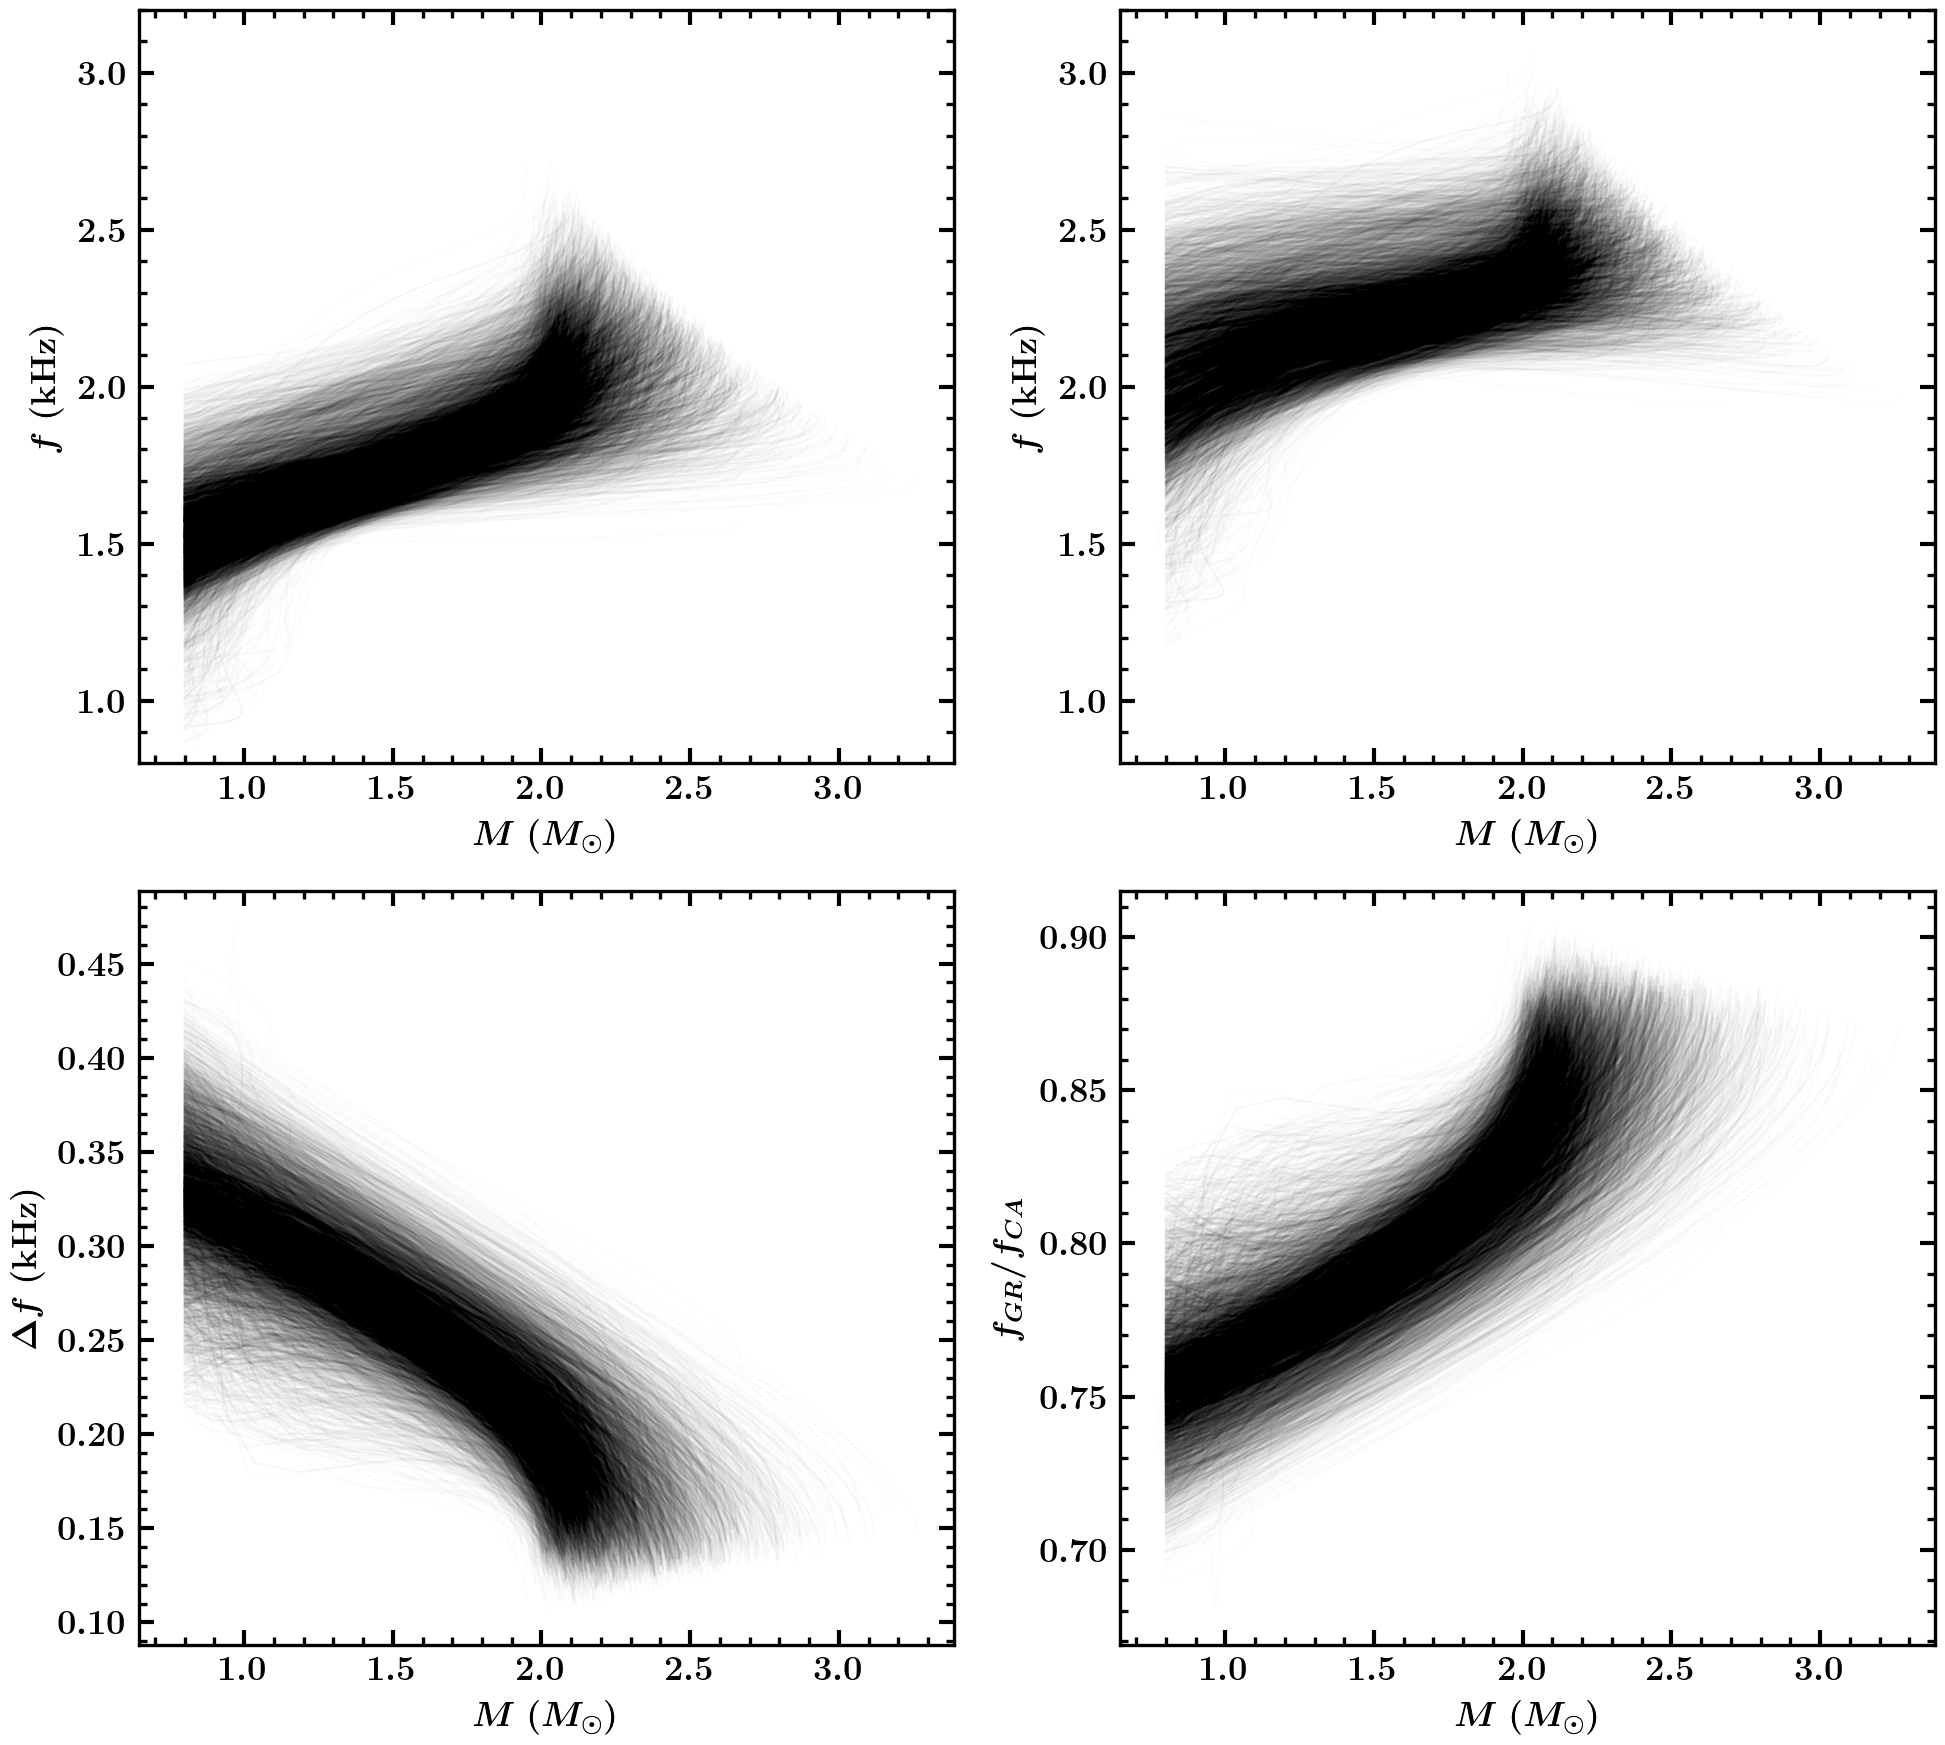

In [7]:
fig, ax = plt.subplots(2,2, figsize= (10*2,9*2))

alpha=0.01

for dat in tqdm(Ensemble_Data.values()):
    M= dat["M"]
    f_GR= dat["f_GR"]
    f_CA= dat["f_CA"]
    
    ax[0,0].plot(M,f_GR,color="black",alpha=alpha)
    ax[0,1].plot(M,f_CA,color="black",alpha=alpha)
    ax[1,0].plot(M,(f_CA-f_GR)/f_GR,color="black",alpha=alpha)
    ax[1,1].plot(M,f_GR/f_CA,color="black",alpha=alpha)

for axes in [ax[0,0],ax[0,1]]:
    axes.set_ylim(0.8,3.2)
    axes.set_ylabel(r'$f \ (\rm{kHz})$', labelpad= 10)

for axes in [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]:
    axes.set_xlabel(r'$M \ (M_\odot)$', labelpad= 10)

ax[1,0].set_ylabel(r'$\Delta f \ (\rm{kHz})$', labelpad= 10)
ax[1,1].set_ylabel(r'$f_{GR}/f_{CA}$', labelpad= 10)

fig.tight_layout()

plt.show()

# Deviation in CA

In [7]:
class Deviation:
    def __init__(self,Dev,M):
        self.Mf_kde= st.gaussian_kde([M,Dev],bw_method=0.1).pdf
        self.M_kde= st.gaussian_kde(M,bw_method=0.1).pdf
        
        self.dev_array= array_from_samp(Dev,200,10)
        self.M_array= array_from_samp(M,100,10)

    def pdf(self,M,d):
        return self.Mf_kde([M,d])[0]/self.M_kde(M)[0]
    
    def mean(self,M):
        Post= Parallel(n_jobs=-1,mmap_mode="r+")(delayed(self.pdf)(M,d) for d in self.dev_array)
        pdf= normalize(self.dev_array,Post)
        return quad(interp1d(self.dev_array,self.dev_array*Post),self.dev_array[0],self.dev_array[-1])[0] 
    
    def __call__(self):
        dev_mean=[]
        for M in tqdm(self.M_array):
            mu= self.mean(M)
            dev_mean.append(mu)
        return self.M_array,dev_mean

In [18]:
M= Data["M"]

M_array, Dev_array= Deviation(Dev,M)()

  0%|          | 0/100 [00:00<?, ?it/s]

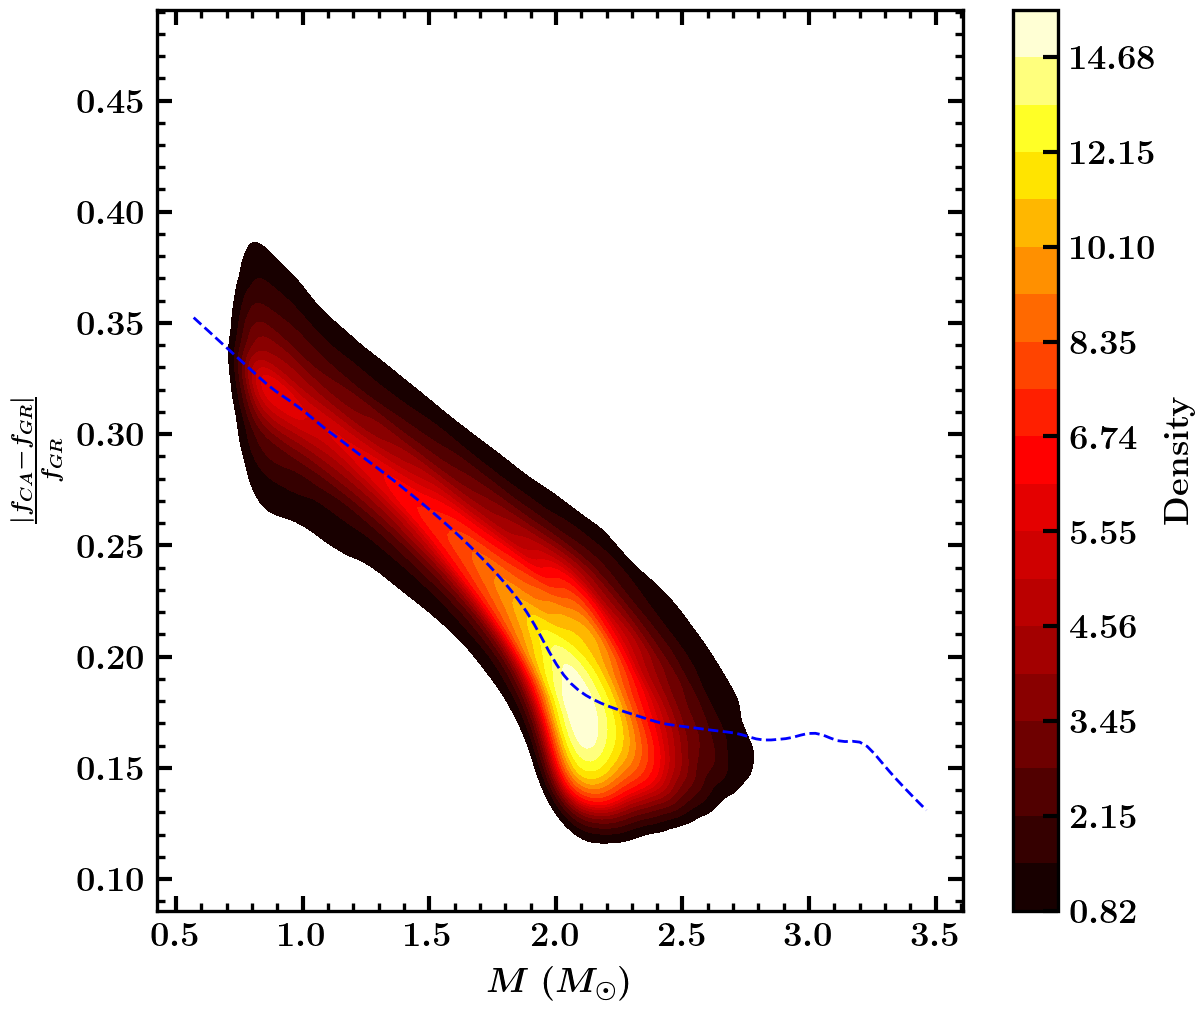

In [20]:
fig, ax = plt.subplots(1, figsize= (10*1.3,9*1.3))

sns.kdeplot(x=M,y=Dev,fill=True,cmap="hot",levels=20,cbar=True,cbar_kws={"label":r"\bf{Density}"})

ax.plot(M_array,Dev_array,"--",linewidth=2,color="Blue",label="Mean")

ax.set_xlabel(r'$M \ (M_\odot)$', labelpad= 10)
ax.set_ylabel(r'$\frac{|f_{CA}-f_{GR}|}{f_{GR}}$', labelpad= 10)

plt.show()

In [176]:
Dev= abs((Data["f_CA"]-Data["f_GR"])/Data["f_GR"])
ratio= Data["f_GR"]/Data["f_CA"]
C= Data["C"]
M= Data["M"]

pams,covs= curve_fit(model,C,Dev)

C_array= array_from_samp(C,200,0)
Dev_fit= np.array([model(ci,*pams) for ci in C_array])

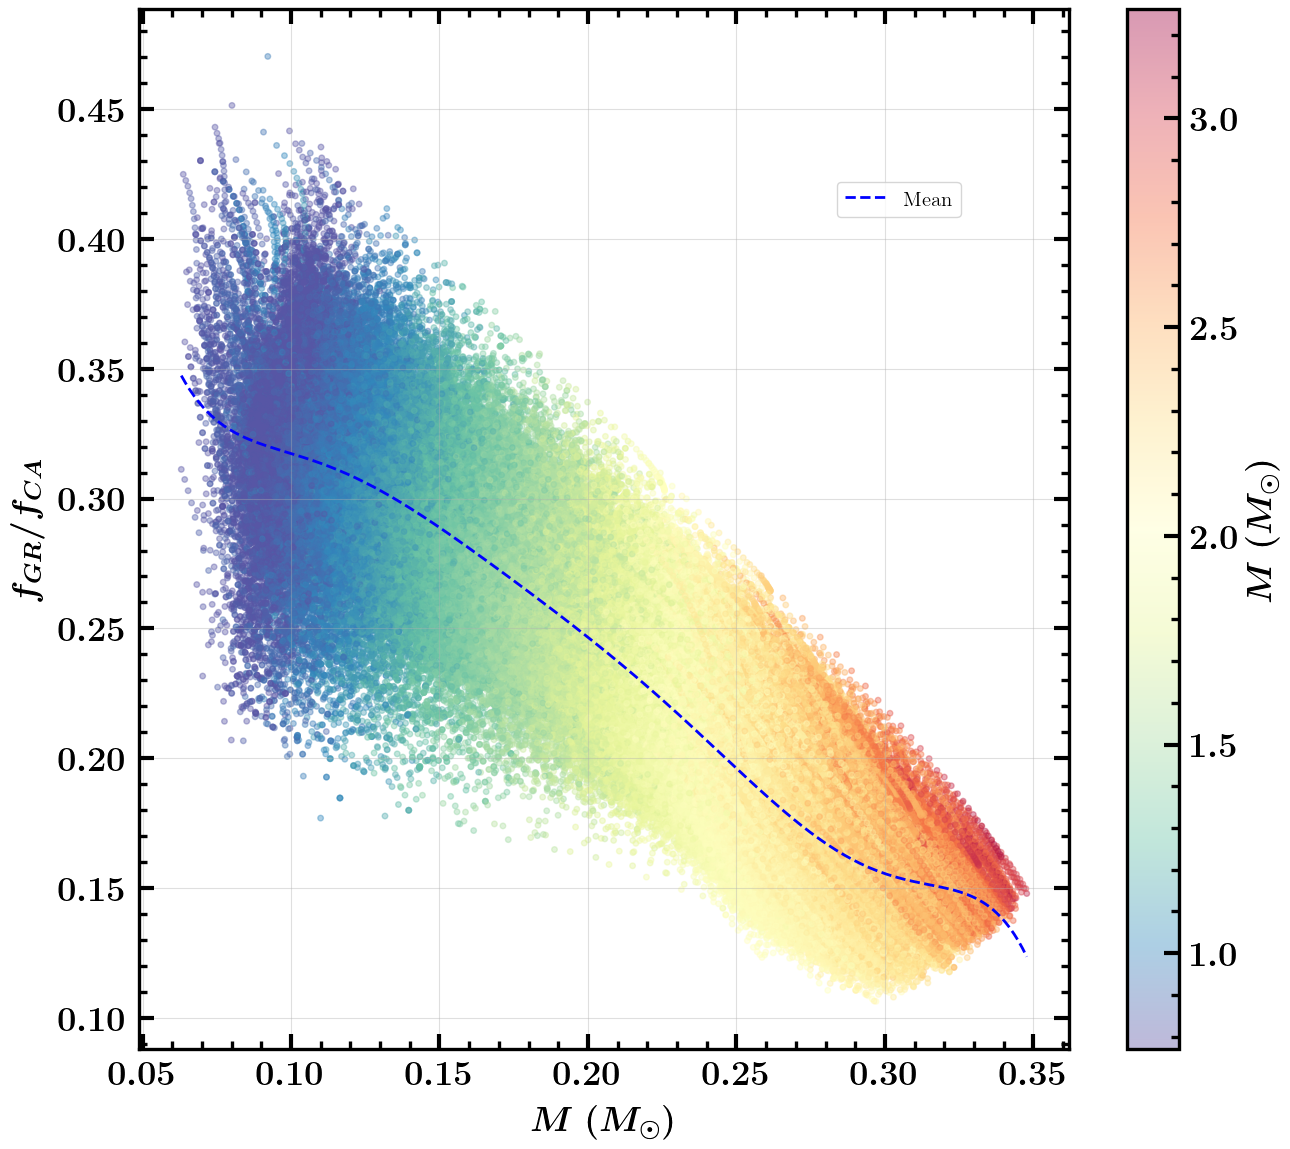

In [178]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

Dev= abs((Data["f_CA"]-Data["f_GR"])/Data["f_GR"])

cmap = plt.get_cmap('Spectral_r', len(Dev))
norm = mpl.colors.Normalize()

scplot= ax.scatter(Data["C"],Dev,c=Data["M"], cmap=cmap, norm=norm, alpha=0.4)
fig.colorbar(scplot, label= r"$M \ (M_\odot)$", ax=ax)

ax.plot(C_array,Dev_fit,"--",linewidth=2,color="black",label="Posterior-Mean")

ax.legend(loc=(0.75,0.8), prop={"size":15})
ax.set_xlabel(r'$M \ (M_\odot)$', labelpad= 10)
ax.set_ylabel(r'$f_{GR}/f_{CA}$', labelpad= 10)
ax.grid(alpha = 0.4)

plt.show()

# fig.savefig("Plots/CA_vs_GR_Envelope_plot.pdf", bbox_inches='tight')

# Envelope plot

In [8]:
class Envelope:
    def __init__(self,Ensemble_Data,M_array,typ="CA"):

        def sub_func(eos):
            if typ=="CA":
                f= eos["f_CA"]
            elif typ=="GR":
                f= eos["f_GR"]
            else:
                f= eos["f_CA"]/eos["f_GR"] - 1
            M2f= interp1d(eos["M"],f,bounds_error=False,fill_value=np.nan)
            f_array= M2f(M_array)
            return f_array
        
        f_grid= Parallel(n_jobs=-1)(delayed(sub_func)(eos) for eos in tqdm(Ensemble_Data.values())) 
            
        self.f_grid= np.array(f_grid)
        self.M_array= M_array
        
    def CI(self,f):
        if len(f)<1:
            return [np.nan]*3
        return np.mean(f),np.quantile(f,0.95),np.quantile(f,0.05)
    
    def __call__(self):
        M_array= self.M_array
        f_mean=[]
        f_pls=[]
        f_minus=[]
        
        def sub_func(i):
            f_samp= self.f_grid[:,i]
            f_samp= f_samp[~np.isnan(f_samp)]
            return self.CI(f_samp)
        
        X= Parallel(-1)(delayed(sub_func)(i) for i in range(len(M_array)))
        
        for x in X:
            mu,pls,minus= x
            f_mean.append(mu)
            f_pls.append(pls)
            f_minus.append(minus)
        return M_array,f_mean,f_pls,f_minus

In [9]:
N=150

CI_CA= Envelope(Ensemble_Data,array_from_samp(Data["M"],N,-3),"CA")()
CI_GR= Envelope(Ensemble_Data,array_from_samp(Data["M"],N,-3),"GR")()
CI_ratio= Envelope(Ensemble_Data,array_from_samp(Data["M"],N,-3),"ratio")()

  0%|          | 0/9607 [00:00<?, ?it/s]

  0%|          | 0/9607 [00:00<?, ?it/s]

  0%|          | 0/9607 [00:00<?, ?it/s]

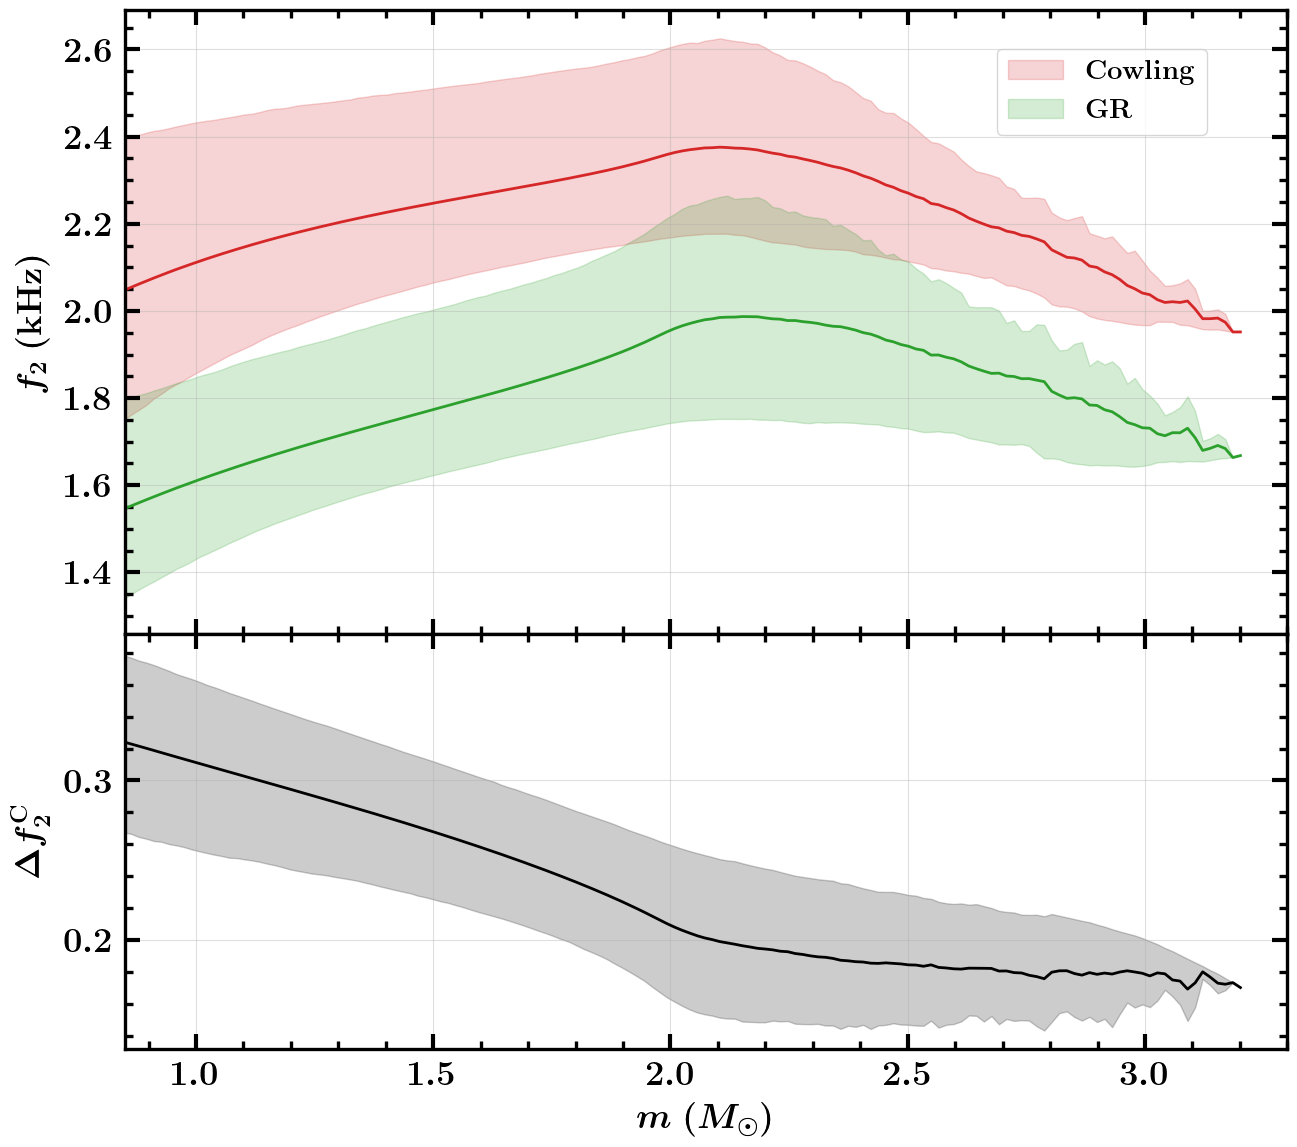

In [23]:
fig, ax = plt.subplots(2, figsize= (10*1.5,9*1.5), sharex=True, gridspec_kw={'height_ratios': [3, 2]})
fig.subplots_adjust(hspace=0)

M_array,f_mean,f_pls,f_minus= CI_CA
ax[0].plot(M_array,f_mean, linewidth= 2, linestyle="-",color="tab:red")
ax[0].fill_between(M_array,f_pls,f_minus,alpha=0.2,color="tab:red",label=r"\bf{Cowling}")

M_array,f_mean,f_pls,f_minus= CI_GR
ax[0].plot(M_array,f_mean, linewidth= 2, linestyle="-",color="tab:green")
ax[0].fill_between(M_array,f_pls,f_minus,alpha=0.2,color="tab:green",label=r"\bf{GR}")

ax[0].legend(loc=(0.75,0.8), prop={"size":20})

ax[0].set_xlim(0.85,3.45)

ax[0].grid(alpha = 0.4)
ax[0].set_ylabel(r"$f_2 \ \mathrm{(kHz)}$", labelpad= 10)

M_array,f_mean,f_pls,f_minus= CI_ratio
ax[1].plot(M_array,f_mean, linewidth= 2, linestyle="-",color="black",label=r"\bf{Mean}")
ax[1].fill_between(M_array,f_pls,f_minus,alpha=0.2,color="black",label=r"\bf{90\% CI}")


ax[1].set_xlim(0.85,3.3)

ax[1].grid(alpha = 0.4)
ax[1].set_ylabel(r'$\Delta f_2^{\rm C}$', labelpad= 10)


ax[1].set_xlabel(r'$m \ (M_\odot)$', labelpad= 8)



plt.show()

fig.savefig("Plots/CA_vs_GR_Envelope_plot2.pdf", bbox_inches='tight')

In [34]:
M_array,f_mean,f_pls,f_minus= CI_GR

ind=0
for i in range(len(M_array)):
    if M_array[i]>2.5:
        ind=i
        break

f_dat= f_mean[ind],f_pls[ind],f_minus[ind]

print(M_array[ind])
print("f=" + error_str(f_dat))

2.5014438947851
f=$1.92^{+0.19}_{-0.19}$


In [35]:
M_array,f_mean,f_pls,f_minus= CI_CA

ind=0
for i in range(len(M_array)):
    if M_array[i]>2.5:
        ind=i
        break

f_dat= f_mean[ind],f_pls[ind],f_minus[ind]

print(M_array[ind])
print("f=" + error_str(f_dat))

2.5014438947851
f=$2.27^{+0.16}_{-0.16}$


In [36]:
M_array,f_mean,f_pls,f_minus= CI_ratio

ind=0
for i in range(len(M_array)):
    if M_array[i]>2.5:
        ind=i
        break

f_dat= f_mean[ind],f_pls[ind],f_minus[ind]

print(M_array[ind])
print("f=" + error_str(f_dat))

2.5014438947851
f=$0.18^{+0.04}_{-0.04}$


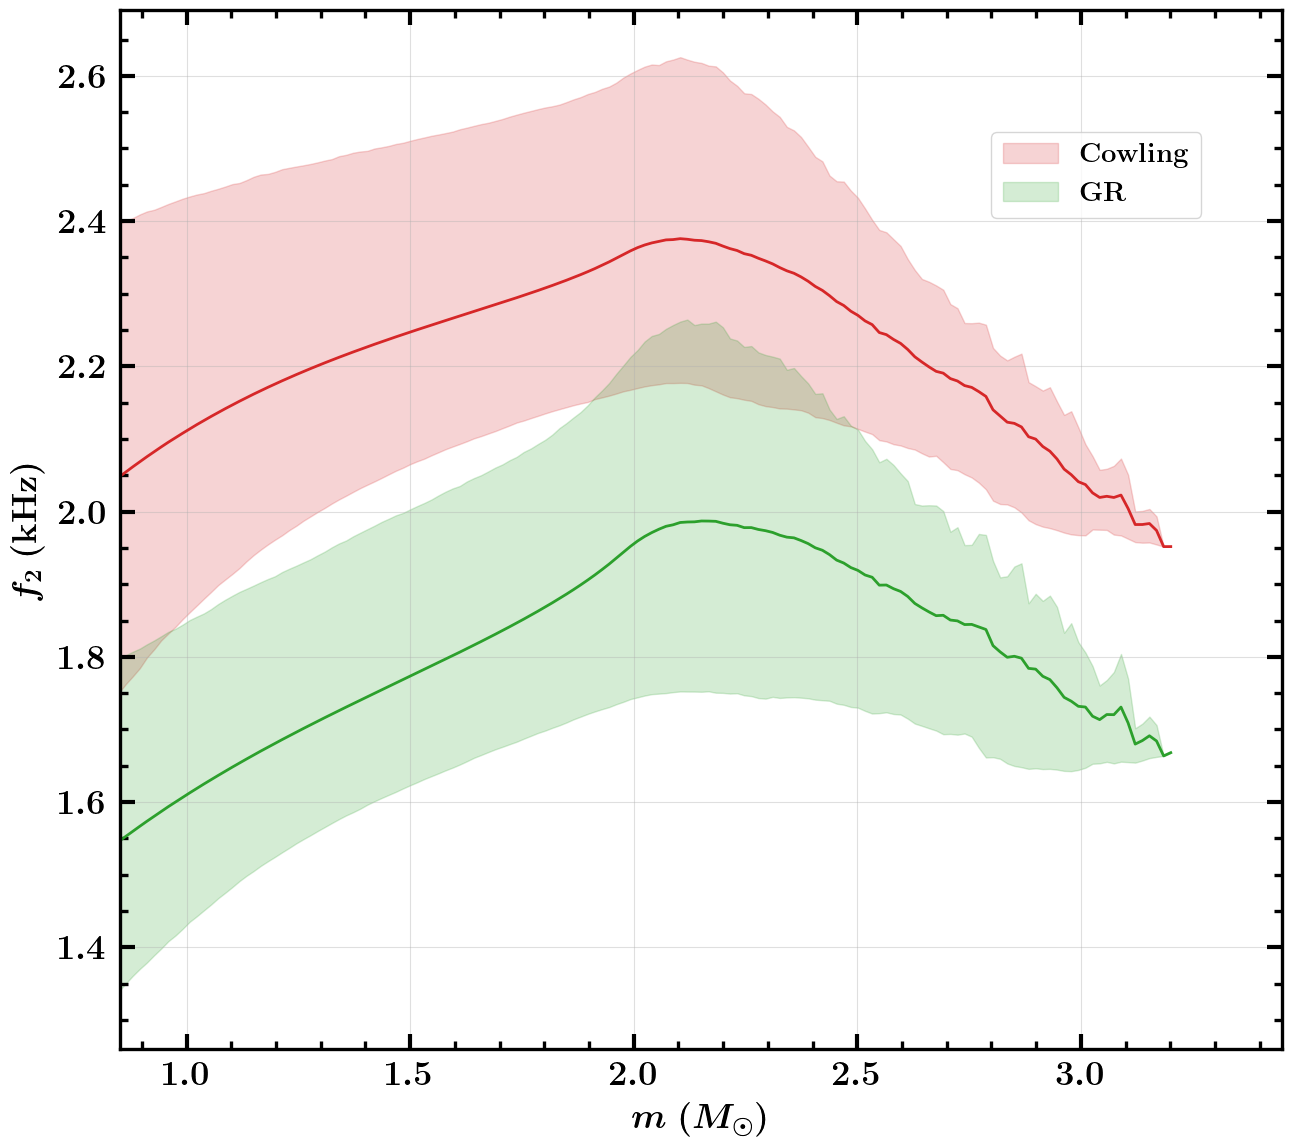

In [12]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

M_array,f_mean,f_pls,f_minus= CI_CA
ax.plot(M_array,f_mean, linewidth= 2, linestyle="-",color="tab:red")
ax.fill_between(M_array,f_pls,f_minus,alpha=0.2,color="tab:red",label=r"\bf{Cowling}")

M_array,f_mean,f_pls,f_minus= CI_GR
ax.plot(M_array,f_mean, linewidth= 2, linestyle="-",color="tab:green")
ax.fill_between(M_array,f_pls,f_minus,alpha=0.2,color="tab:green",label=r"\bf{GR}")

ax.legend(loc=(0.75,0.8), prop={"size":20})

ax.set_xlim(0.85,3.45)

ax.grid(alpha = 0.4)
ax.set_xlabel(r'$m \ (M_\odot)$', labelpad= 8)
ax.set_ylabel(r"$f_2 \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()

fig.savefig("Plots/CA_vs_GR_Envelope_plot.pdf", bbox_inches='tight')

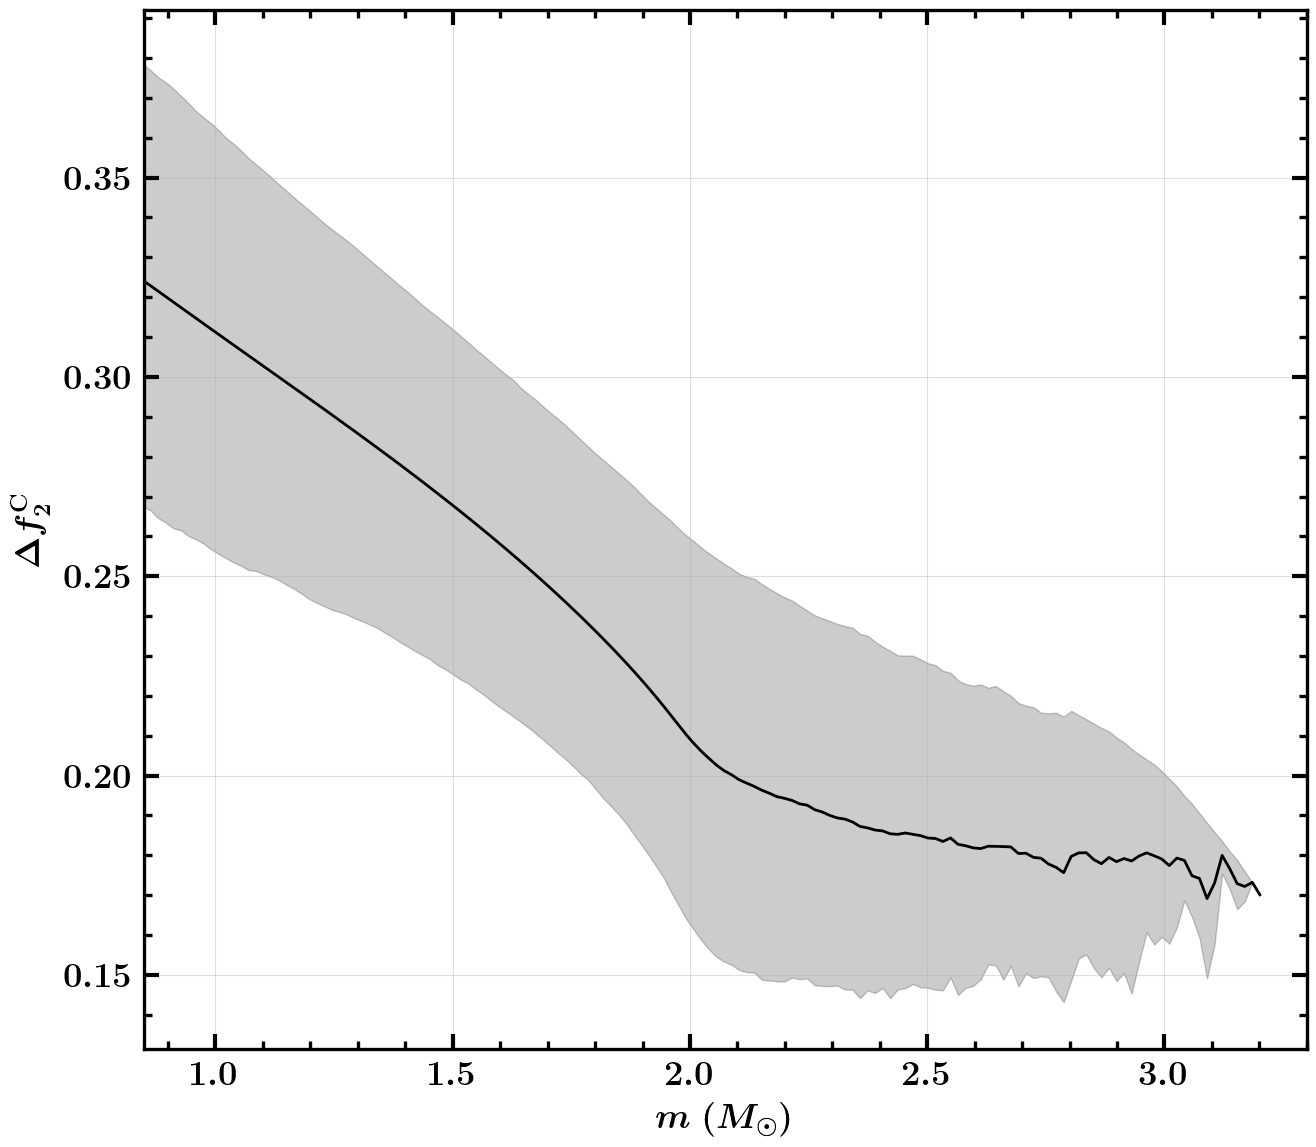

In [27]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

M_array,f_mean,f_pls,f_minus= CI_ratio
ax.plot(M_array,f_mean, linewidth= 2, linestyle="-",color="black",label=r"\bf{Mean}")
ax.fill_between(M_array,f_pls,f_minus,alpha=0.2,color="black",label=r"\bf{90\% CI}")

# ax.legend(loc=(0.7,0.4), prop={"size":15})

ax.set_xlim(0.85,3.3)
# ax.set_ylim(0.71,0.888)

ax.grid(alpha = 0.4)
ax.set_xlabel(r'$m \ (M_\odot)$', labelpad= 8)
ax.set_ylabel(r'$\Delta f_2^{\rm C}$', labelpad= 10)

plt.show()

fig.savefig("Plots/CA_ratio_GR_Envelope_plot.pdf", bbox_inches='tight')

# 1D posteriors

In [117]:
class GW_posterior:
    def __init__(self,M1_samples,M2_samples,N):        
        self.M1_samples=M1_samples
        self.M2_samples=M2_samples
        self.N=N
        self.M1_kde= st.gaussian_kde(M1_samples)
        self.M2_kde= st.gaussian_kde(M2_samples)
                
    def EOS_set_input(self,EOS_set,ID="CA"):
        M= EOS_set["M"]
        if ID== "CA":
            f= EOS_set["f_CA"]
        else:
            f= EOS_set["f_GR"]
        self.Mf_kde= st.gaussian_kde([M,f]).pdf
        self.M_kde= st.gaussian_kde(M).pdf
        return
        
    def prior(self,M,f):
        return self.Mf_kde([M,f])[0]/self.M_kde(M)[0]
        
    def likelihood(self,M):
        return self.M2PDF(M)
    
    def posterior(self,f):
        sub_func= lambda M: self.prior(M,f)*self.likelihood(M)
        m1,m2= self.M_limits
        return integrator(sub_func,[[m1,m2]],self.N)()
        
    def PDF_fmode(self,f_vals):
        Post= Parallel(n_jobs=-1,mmap_mode="r+")(delayed(self.posterior)(f) for f in tqdm(f_vals))
        return normalize(f_vals,Post) 
    
    def __call__(self,i):
        self.i=i
        self.M2PDF=[self.M1_kde,self.M2_kde][i-1].pdf
        self.M_limits= [array_from_samp(self.M1_samples,2),array_from_samp(self.M2_samples,2)][i-1]
        return self

In [146]:
# writeDict("Cowling_Posterior",{"GW170817":GW170817,"GW190425":GW190425})

GW170817= readDict("Cowling_Posterior")["GW170817"]
GW190425= readDict("Cowling_Posterior")["GW190425"]

In [148]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

ax.plot(GW170817["Data"]["f1_GR"],GW170817["PDF"]["f1_GR"], linestyle="-", linewidth=2, color="tab:blue")
ax.fill_between(GW170817["Data"]["f1_GR"],GW170817["PDF"]["f1_GR"], alpha=0.2, linestyle="-", linewidth=2, color="tab:blue")
ax.plot(GW170817["Data"]["f2_GR"],GW170817["PDF"]["f2_GR"], linestyle="-", linewidth=2, color="tab:orange")
ax.fill_between(GW170817["Data"]["f2_GR"],GW170817["PDF"]["f2_GR"], alpha=0.2, linestyle="-", linewidth=2, color="tab:orange")

ax.plot(GW170817["Data"]["f1_CA"],GW170817["PDF"]["f1_CA"], linestyle="--", linewidth=2, color="tab:blue")
ax.plot(GW170817["Data"]["f2_CA"],GW170817["PDF"]["f2_CA"], linestyle="--", linewidth=2, color="tab:orange")

ax.plot(GW190425["Data"]["f1_GR"],GW190425["PDF"]["f1_GR"], linestyle="-", linewidth=2, color="tab:green")
ax.fill_between(GW190425["Data"]["f1_GR"],GW190425["PDF"]["f1_GR"], alpha=0.2, linestyle="-", linewidth=2, color="tab:green")
ax.plot(GW190425["Data"]["f2_GR"],GW190425["PDF"]["f2_GR"], linestyle="-", linewidth=2, color="tab:red")
ax.fill_between(GW190425["Data"]["f2_GR"],GW190425["PDF"]["f2_GR"], alpha=0.2, linestyle="-", linewidth=2, color="tab:red")

ax.plot(GW190425["Data"]["f1_CA"],GW190425["PDF"]["f1_CA"], linestyle="--", linewidth=2, color="tab:green")
ax.plot(GW190425["Data"]["f2_CA"],GW190425["PDF"]["f2_CA"], linestyle="--", linewidth=2, color="tab:red")
     
    
ax.plot([],[],linestyle="",label=r"\bf{GW170817}")
ax.plot([],[],label=r"\bf{Primary Component}",color="tab:blue", linewidth= 2)
ax.plot([],[],label=r"\bf{Secondary Component}",color="tab:orange", linewidth= 2)

leg1= ax.legend(loc=(0.685,0.65), prop={"size":15})

ax.plot([],[],linestyle="",label=r"\bf{GW190425}")
ax.plot([],[],label=r"\bf{Primary Component}",color="tab:green", linewidth= 2)
ax.plot([],[],label=r"\bf{Secondary Component}",color="tab:red", linewidth= 2)

lines= ax.get_lines()
leg2= ax.legend([lines[i] for i in [-3,-2,-1]],[lines[i].get_label() for i in [-3,-2,-1]],loc=(0.685,0.5), prop={"size":15})

ax.plot([],[],label=r"\bf{Cowling Approximation}",color="black", linestyle="--", linewidth= 2)
ax.plot([],[],label=r"\bf{Full-GR}",color="black", linestyle="-", linewidth= 2)

lines= ax.get_lines()
leg3= ax.legend([lines[i] for i in [-2,-1]],[lines[i].get_label() for i in [-2,-1]],loc=(0.685,0.8), prop={"size":15})

ax.add_artist(leg1)
ax.add_artist(leg2)

ax.set_ylim(0.01,4.2)
ax.set_xlim(1.1,3.15)

ax.grid(alpha = 0.4)
ax.set_ylabel(r"$\rm PDF \ \mathrm{(kHz)}^{-1}$", labelpad= 10)
ax.set_xlabel(r"$f \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()

fig.savefig("Plots/1D_CA_vs_GR_events.pdf", bbox_inches='tight')

In [151]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

sns.kdeplot(Data["f_GR_max"],ax=ax,color="red",linewidth=2,fill=True) 
sns.kdeplot(Data["f_CA_max"],ax=ax,color="red",linewidth=2,linestyle="--") 

sns.kdeplot(Data["f_GR_1.4"],ax=ax,color="orange",linewidth=2,fill=True) 
sns.kdeplot(Data["f_CA_1.4"],ax=ax,color="orange",linewidth=2,linestyle="--") 
        
ax.plot([],[],label=r"\bf{Maximum Mass NS}",color="red", linewidth= 2)
ax.plot([],[],label=r"\bf{Canonical Mass NS}",color="orange", linewidth= 2)

leg1= ax.legend(loc=(0.7,0.8), prop={"size":15})

ax.plot([],[],label=r"\bf{Cowling Approximation}",color="black", linestyle="--", linewidth= 2)
ax.plot([],[],label=r"\bf{Full-GR}",color="black", linestyle="-", linewidth= 2)

lines= ax.get_lines()
leg2= ax.legend([lines[i] for i in [-2,-1]],[lines[i].get_label() for i in [-2,-1]],loc=(0.7,0.7), prop={"size":15})

ax.add_artist(leg1)

ax.set_ylim(0.01,4.48)
ax.grid(alpha = 0.4)
ax.set_ylabel(r"$\rm PDF \ \mathrm{(kHz)}^{-1}$", labelpad= 10)
ax.set_xlabel(r"$f \ \mathrm{(kHz)}$", labelpad= 10)

plt.show()

fig.savefig("Plots/1D_CA_vs_GR_1.4_and_max.pdf", bbox_inches='tight')

# UR

In [162]:
def model(x,a0,a1,a2,a3,a4,a5,a6,a7):
    return a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4 + a5*x**5 + a6*x**6 + a7*x**7

def UR(x,y,model,plot,display_result):
    
    x2y,Result= Best_Fit(x,y,Model_func=model,plot=plot,display_result=False)
    
    if display_result==True:
        Result.var_names.append("chi^2")
        pd.options.display.float_format = '{:,.3e}'.format
        tab= pd.DataFrame(np.concatenate([Result.Params,[Result.redchi]]),index=Result.var_names)      
        display(tab)
                
    return x2y,Result

In [23]:
x2y,Result= UR(np.log10(Data["L"]),Data["C"]*(Data["f_GR"]/Data["f_CA"]),model,False,True)

x_fit= array_from_samp(Result.x_data,100,10)
y_fit= x2y(x_fit)

x_data= Result.x_data
y_data= Result.y_data
residual= abs(Result.Bestfit_data-Result.y_data)/Result.Bestfit_data

n= len(x_data)
M_data= data_sorter(np.log10(Data["L"]),Data["M"])[1]

0
a0     3.271e-01
a1    -9.194e-02
a2     2.147e-02
a3    -1.851e-02
a4     9.234e-03
a5    -2.291e-03
a6     2.848e-04
a7    -1.418e-05
chi^2  3.157e-06

### $f_{GR} (C,\Lambda, f_{CA}) = \frac{f_{CA}}{C} \sum_{0}^{7} a_n \log^n (\Lambda)$

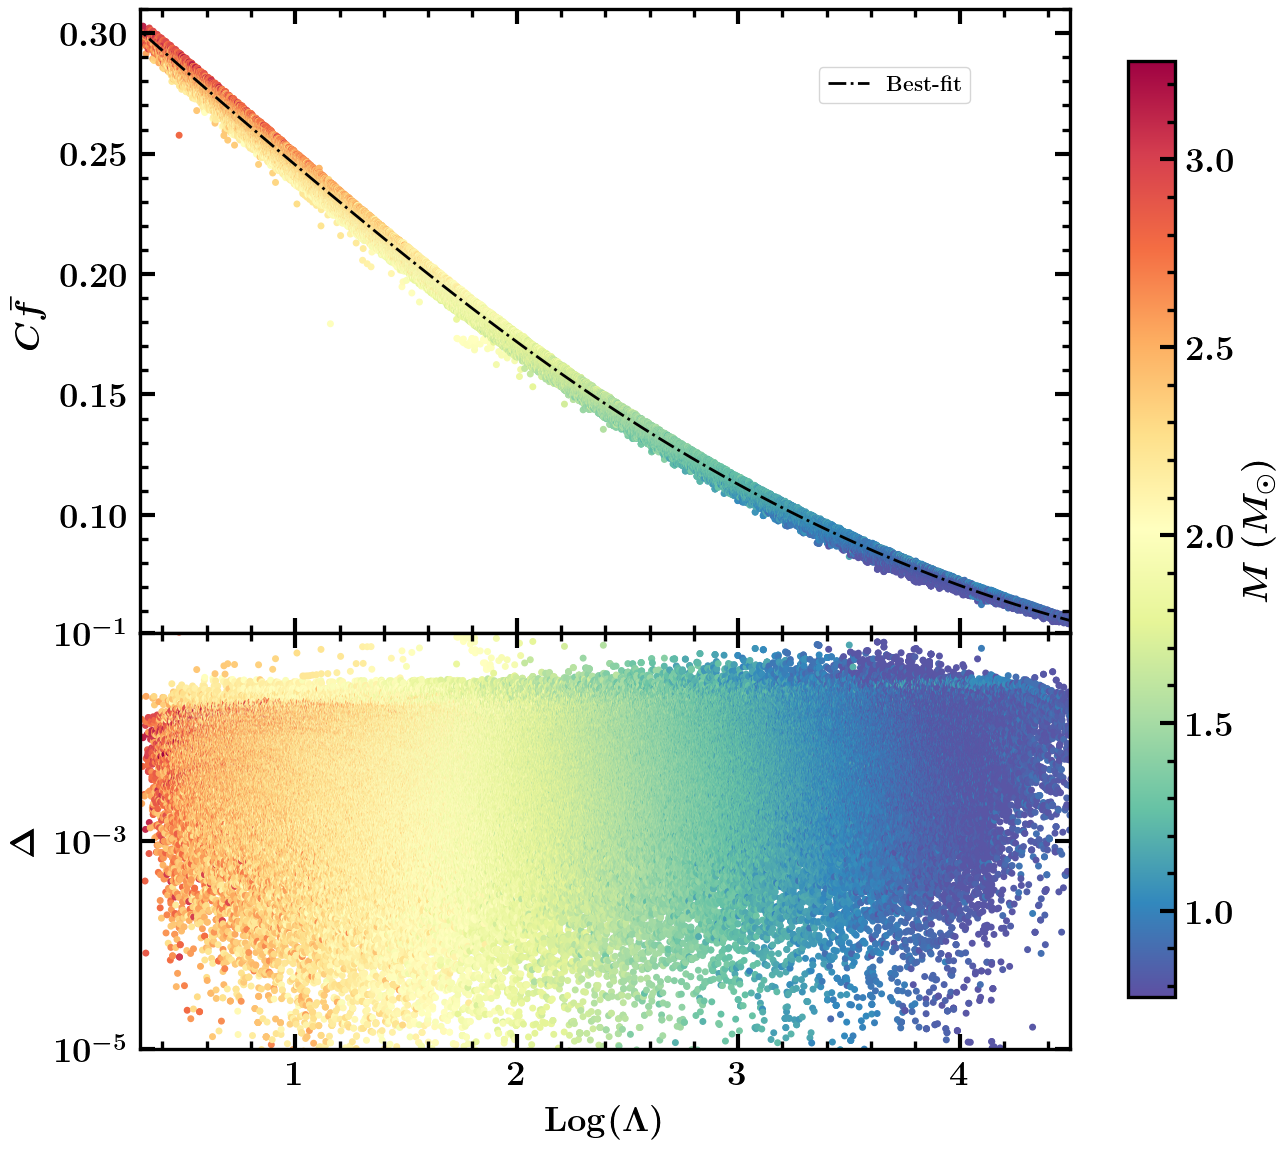

In [13]:
fig, ax = plt.subplots(2, figsize= (10*1.5,9*1.5), sharex=True, gridspec_kw={'height_ratios': [3, 2]})
fig.subplots_adjust(hspace=0)

cmap = plt.get_cmap('Spectral_r', n)
norm = mpl.colors.Normalize()

ax[0].plot(x_fit,y_fit, "-.", color="black",linewidth=2, label=r"\bf{Best-fit}", zorder=100)

scplot= ax[0].scatter(x_data,y_data, c=M_data, cmap=cmap, norm=norm)
ax[1].scatter(x_data,residual, c=M_data, cmap=cmap, norm=norm)

fig.colorbar(scplot, label= r"$M \ (M_\odot)$", ax=ax.flatten(), shrink=0.9)

ax[0].set_ylabel(r"$C\bar{f}$", labelpad= 10)
ax[0].set_ylim(0.051,0.31)
ax[0].legend(loc=(0.73,0.85), prop={"size":15})

ax[1].set_xlabel(r"$\mathrm{Log}(\Lambda)$", labelpad= 10)
ax[1].set_ylabel(r"$\Delta$", labelpad= 10)
ax[1].set_yscale("log")
ax[1].set_xlim(0.3,4.5)
ax[1].set_ylim(1e-5,0.1)

plt.show()

# fig.savefig("Plots/fLove.pdf", bbox_inches='tight')

In [24]:
def f_gr(C,L,f_ca):
    x= x2y(np.log10(L))
    return x*f_ca/C

eos_0= Ensemble_Data["eos_0"]

M= eos_0["M"]
C= eos_0["C"]
L= eos_0["L"]
f_c= eos_0["f_CA"]
f_g= eos_0["f_GR"]

f_g_new= [f_gr(c,l,f) for c,l,f in zip(C,L,f_c)]

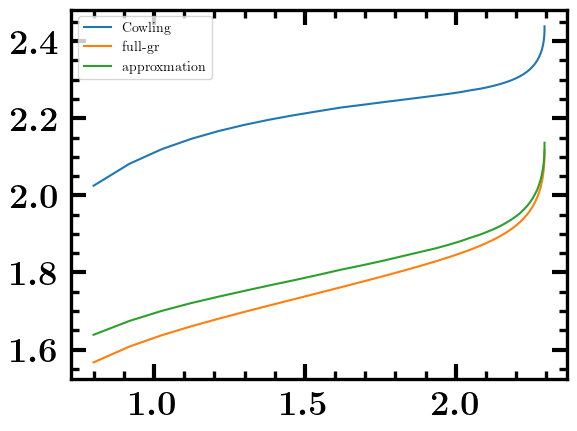

In [25]:
plt.plot(M,f_c, label="Cowling")
plt.plot(M,f_g, label="full-gr")
plt.plot(M,f_g_new, label="approxmation")

plt.legend(prop={"size":10})

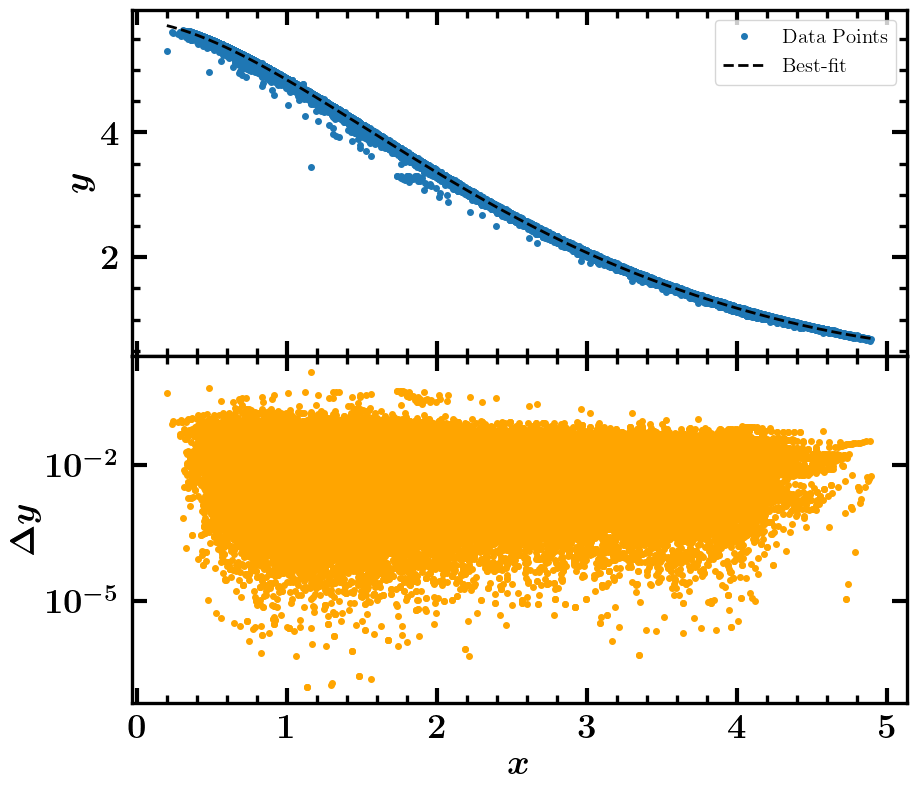

0
a0     5.793e+00
a1    -2.157e-01
a2    -1.106e+00
a3     4.572e-01
a4    -1.081e-01
a5     1.959e-02
a6    -2.434e-03
a7     1.385e-04
chi^2  1.651e-04

In [26]:
# f-love relation

x2y,Result= UR(np.log10(Data["L"]),Data["M"]*(Data["f_GR"]),model,True,True)

In [27]:
def f_gr(M,L):
    x= x2y(np.log10(L))
    return x/M

eos_0= Ensemble_Data["eos_0"]

M= eos_0["M"]
C= eos_0["C"]
L= eos_0["L"]
f_c= eos_0["f_CA"]
f_g= eos_0["f_GR"]

f_g_prime= [f_gr(m,l) for m,l in zip(M,L)]

In [30]:
plt.plot(M,f_c, label="Cowling")
plt.plot(M,f_g, label="full-gr")
plt.plot(M,f_g_new, label="approxmation")
plt.plot(M,f_g_prime, label="approxmation from f-love relation")

plt.legend(prop={"size":10})